In [1]:
import os
import torch

os.environ["TORCH_HOME"] = "/data/jdsu/ckpts/torch"
torch.cuda.set_device(1)

In [2]:
import torch
import yaml
from omegaconf import OmegaConf

# load ckpt
ckpt_path = "./checkpoints/reverse_30_epochs.ckpt"
# encode, decoder, loss, quan_conv, post_quan_conv
# for key in ckpt.keys():
    # if key.startswith("first_stage_model.loss"):
    #     print(key)
    # print(key)

# load model config
config_path = "./logs/vqgan_imagenet_f16_1024/configs/vqgan_imagenet_f16_1024.yaml"
config = OmegaConf.load(config_path)
# print(config["model"]["params"])
print(f"pretrained model config: \n{yaml.dump(OmegaConf.to_container(config.model.params))}")

pretrained model config: 
ddconfig:
  attn_resolutions:
  - 16
  ch: 128
  ch_mult:
  - 1
  - 1
  - 2
  - 2
  - 4
  double_z: false
  dropout: 0.0
  in_channels: 3
  num_res_blocks: 2
  out_ch: 3
  resolution: 256
  z_channels: 256
embed_dim: 256
lossconfig:
  params:
    codebook_weight: 1.0
    disc_conditional: false
    disc_in_channels: 3
    disc_start: 0
    disc_weight: 0.8
  target: taming.modules.losses.vqperceptual.VQLPIPSWithDiscriminator
n_embed: 1024



In [4]:
# load vqgan model, include encoder, decoder, quantize, and loss module
from taming.models.vqgan import VQModel

# vqgan_model = VQModel(**config.model.params).eval()  # 900M
vqgan_model = VQModel(**config.model.params) # 900M
print(vqgan_model)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/data/jdsu/miniconda3/envs/taming/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/jdsu/miniconda3/envs/taming/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
VQModel(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down): ModuleList(
      (0-1): 2 x Module(
        (block): ModuleList(
          (0-1): 2 x ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (attn): ModuleList()
        (downsample): Downsample(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
        )
      )
      (2): Module(
        (block): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps

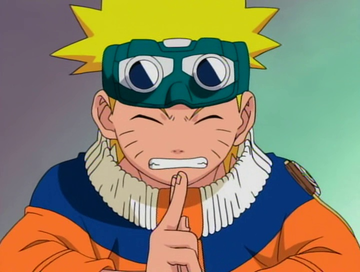

In [5]:
from PIL import Image
import numpy as np

def load_image(image_path, device):
    image = Image.open(image_path)
    if not image.mode == "RGB":
        image = image.convert("RGB")
    image = np.array(image).astype(np.uint8)
    image = (image / 127.5 - 1.0).astype(np.float32)
    image = torch.tensor(image.transpose(2, 0, 1)[None]).to(dtype=torch.float32, device=device)
    return image

def show_image(image):
    image = image.detach().cpu().numpy().transpose(0, 2, 3, 1)  # image
    image = (image + 1.0) * 127.5
    image = Image.fromarray(image[0].astype(np.uint8))
    image.show()

image_path = "naruto.png"
image = load_image(image_path, device=vqgan_model.device)
# print(image)
show_image(image)

image code.shape: torch.Size([1, 256, 17, 22])
embed loss: 0.04834360629320145
image indices.shape: torch.Size([374])
rec image.shape: torch.Size([1, 3, 272, 352])


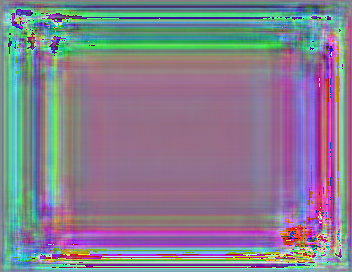

In [5]:
# random reconstruct an image (seg)
image_code, embed_loss, (_, _, image_indices) = vqgan_model.encode(image)
print(f"image code.shape: {image_code.shape}")  # downsample, 272 / 16 = 17, embed_dim = 256
print(f"embed loss: {embed_loss}")
print(f"image indices.shape: {image_indices.shape}")    # most of indices is 873 (to be trained)
# reconstruct
rec_image = vqgan_model.decode(image_code)
print(f"rec image.shape: {rec_image.shape}")
show_image(rec_image)

Deleting key decoder.conv_in.weight from state_dict.
Deleting key decoder.conv_in.bias from state_dict.
Deleting key decoder.mid.block_1.norm1.weight from state_dict.
Deleting key decoder.mid.block_1.norm1.bias from state_dict.
Deleting key decoder.mid.block_1.conv1.weight from state_dict.
Deleting key decoder.mid.block_1.conv1.bias from state_dict.
Deleting key decoder.mid.block_1.norm2.weight from state_dict.
Deleting key decoder.mid.block_1.norm2.bias from state_dict.
Deleting key decoder.mid.block_1.conv2.weight from state_dict.
Deleting key decoder.mid.block_1.conv2.bias from state_dict.
Deleting key decoder.mid.attn_1.norm.weight from state_dict.
Deleting key decoder.mid.attn_1.norm.bias from state_dict.
Deleting key decoder.mid.attn_1.q.weight from state_dict.
Deleting key decoder.mid.attn_1.q.bias from state_dict.
Deleting key decoder.mid.attn_1.k.weight from state_dict.
Deleting key decoder.mid.attn_1.k.bias from state_dict.
Deleting key decoder.mid.attn_1.v.weight from state_

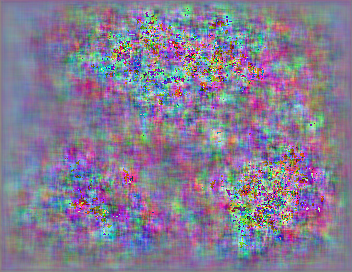

In [6]:
# load pretrained weights
vqgan_model.init_from_ckpt(ckpt_path, ignore_keys=["decoder"])
# random reconstruct an image (seg)
image_code, embed_loss, (_, _, image_indices) = vqgan_model.encode(image)
print(f"image code.shape: {image_code.shape}")  # downsample, 272 / 16 = 17, embed_dim = 256
print(f"embed loss: {embed_loss}")
print(f"image indices.shape: {image_indices.shape}")    # most of indices is 873 (to be trained)
# reconstruct
rec_image = vqgan_model.decode(image_code)
print(f"rec image.shape: {rec_image.shape}")
show_image(rec_image)

Deleting key decoder.conv_in.weight from state_dict.
Deleting key decoder.conv_in.bias from state_dict.
Deleting key decoder.mid.block_1.norm1.weight from state_dict.
Deleting key decoder.mid.block_1.norm1.bias from state_dict.
Deleting key decoder.mid.block_1.conv1.weight from state_dict.
Deleting key decoder.mid.block_1.conv1.bias from state_dict.
Deleting key decoder.mid.block_1.norm2.weight from state_dict.
Deleting key decoder.mid.block_1.norm2.bias from state_dict.
Deleting key decoder.mid.block_1.conv2.weight from state_dict.
Deleting key decoder.mid.block_1.conv2.bias from state_dict.
Deleting key decoder.mid.attn_1.norm.weight from state_dict.
Deleting key decoder.mid.attn_1.norm.bias from state_dict.
Deleting key decoder.mid.attn_1.q.weight from state_dict.
Deleting key decoder.mid.attn_1.q.bias from state_dict.
Deleting key decoder.mid.attn_1.k.weight from state_dict.
Deleting key decoder.mid.attn_1.k.bias from state_dict.
Deleting key decoder.mid.attn_1.v.weight from state_

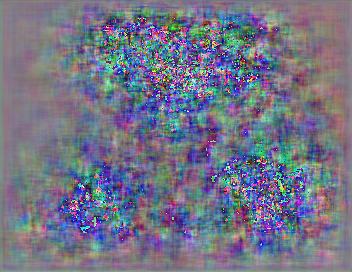

In [7]:
# load pretrained weights
vqgan_model.init_from_ckpt(ckpt_path, ignore_keys=["decoder", "loss.discriminator"])
# random reconstruct an image (seg)
image_code, embed_loss, (_, _, image_indices) = vqgan_model.encode(image)
print(f"image code.shape: {image_code.shape}")  # downsample, 272 / 16 = 17, embed_dim = 256
print(f"embed loss: {embed_loss}")
print(f"image indices.shape: {image_indices.shape}")    # most of indices is 873 (to be trained)
# reconstruct
rec_image = vqgan_model.decode(image_code)
print(f"rec image.shape: {rec_image.shape}")
show_image(rec_image)

Restored from ./checkpoints/reverse_30_epochs.ckpt
image code.shape: torch.Size([1, 256, 17, 22])
embed loss: 0.005633603781461716
image indices.shape: torch.Size([374])
rec image.shape: torch.Size([1, 3, 272, 352])


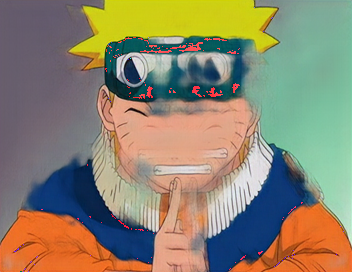

In [6]:
# load pretrained weights
vqgan_model.init_from_ckpt(ckpt_path)
# random reconstruct an image (seg)
image_code, embed_loss, (_, _, image_indices) = vqgan_model.encode(image)
print(f"image code.shape: {image_code.shape}")  # downsample, 272 / 16 = 17, embed_dim = 256
print(f"embed loss: {embed_loss}")
print(f"image indices.shape: {image_indices.shape}")    # most of indices is 873 (to be trained)
# reconstruct
rec_image = vqgan_model.decode(image_code)
print(f"rec image.shape: {rec_image.shape}")
show_image(rec_image)

In [4]:
# train: 1. load data
from torch.utils.data import DataLoader, Dataset
import collections

from PIL import Image
import numpy as np

# this dataset only contains 1 image
class TestTrainSet(Dataset):
    def __init__(self, image_path, resolution=(256,256), length=2000):
        super().__init__()
        image = Image.open(image_path)
        image = image.resize(resolution)
        if not image.mode == "RGB":
            image = image.convert("RGB")
        image = np.array(image).astype(np.uint8)
        image = (image / 127.5 - 1.0).astype(np.float32)
        image = torch.tensor(image).to(dtype=torch.float32)   # h,w,c
        # resize
        self.image = image  # naruto.png
        self.length = length
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        # assert index == 0, f"index out of range: {index}(index)/{1}(data_num)"
        return {"image": self.image}

def custom_collate(batch):
    # print(f"batch[0]: {batch[0]}")  # batch is the first data
    # print(f"batch[1]: {batch[1]}")
    elem = batch[0]
    elem_type = type(elem)
    # print(elem_type)
    # print(isinstance(elem, int))
    # print(isinstance(elem, float))
    # print(elem_type.__module__ == 'numpy' and elem_type.__name__ != 'str_')
    # print(isinstance(elem, torch.Tensor))
    # print(isinstance(elem, collections.abc.Mapping))
    image_tensor = [d["image"] for d in batch]
    image_tensor = torch.stack(image_tensor, 0, out=None)
    return {"image": image_tensor}

train_set = TestTrainSet("naruto.png")
train_loader = DataLoader(train_set, batch_size=16, shuffle=True, collate_fn=custom_collate)
for data in train_loader:
    # print(type(data))
    # for key in data:
    #     print(f"key: {key}, type: {type(data[key])}")
    # print(data[key].shape)
    print(data["image"].shape)
    break

torch.Size([16, 256, 256, 3])


In [5]:
# load pretrained weights and ignore decoder and discriminator
vqgan_model.init_from_ckpt(ckpt_path, ignore_keys=["decoder", "loss.discriminator"])
vqgan_model.freeze_pretrained_weights()

Deleting key decoder.conv_in.weight from state_dict.
Deleting key decoder.conv_in.bias from state_dict.
Deleting key decoder.mid.block_1.norm1.weight from state_dict.
Deleting key decoder.mid.block_1.norm1.bias from state_dict.
Deleting key decoder.mid.block_1.conv1.weight from state_dict.
Deleting key decoder.mid.block_1.conv1.bias from state_dict.
Deleting key decoder.mid.block_1.norm2.weight from state_dict.
Deleting key decoder.mid.block_1.norm2.bias from state_dict.
Deleting key decoder.mid.block_1.conv2.weight from state_dict.
Deleting key decoder.mid.block_1.conv2.bias from state_dict.
Deleting key decoder.mid.attn_1.norm.weight from state_dict.
Deleting key decoder.mid.attn_1.norm.bias from state_dict.
Deleting key decoder.mid.attn_1.q.weight from state_dict.
Deleting key decoder.mid.attn_1.q.bias from state_dict.
Deleting key decoder.mid.attn_1.k.weight from state_dict.
Deleting key decoder.mid.attn_1.k.bias from state_dict.
Deleting key decoder.mid.attn_1.v.weight from state_

In [6]:
from pytorch_lightning.trainer import Trainer

trainer = Trainer(gpus=[1], max_epochs=10)
trainer.fit(vqgan_model, train_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/data/jdsu/miniconda3/envs/taming/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: you defined a validation_step but have no val_dataloader. Skipping validation loop
  warnings.warn(*args, **kwargs)

  | Name            | Type                     | Params
-------------------------------------------------------------
0 | encoder         | Encoder                  | 29.3 M
1 | decoder         | Decoder                  | 42.4 M
2 | loss            | VQLPIPSWithDiscriminator | 17.5 M
3 | quantize        | VectorQuantizer2         | 262 K 
4 | quant_conv      | Conv2d                   | 65.8 K
5 | post_quant_conv | Conv2d                   | 65.8 K


/data/jdsu/miniconda3/envs/taming/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 9: 100%|██████████| 125/125 [01:40<00:00,  1.25it/s, loss=0.353, v_num=7, train/aeloss_step=0.0823, train/discloss_step=0.611, train/aeloss_epoch=0.108, train/discloss_epoch=0.677]


1

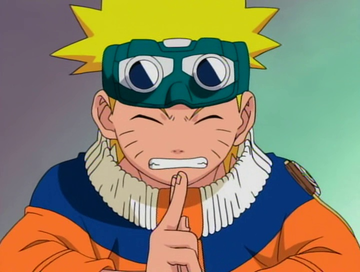

image code.shape: torch.Size([1, 256, 17, 22])
embed loss: 0.015047342516481876
image indices.shape: torch.Size([374])


rec image.shape: torch.Size([1, 3, 272, 352])


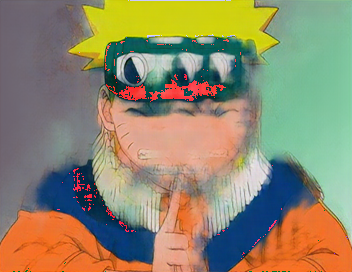

In [7]:
from PIL import Image
import numpy as np

def load_image(image_path, device):
    image = Image.open(image_path)
    if not image.mode == "RGB":
        image = image.convert("RGB")
    image = np.array(image).astype(np.uint8)
    image = (image / 127.5 - 1.0).astype(np.float32)
    image = torch.tensor(image.transpose(2, 0, 1)[None]).to(dtype=torch.float32, device=device)
    return image

def show_image(image):
    image = image.detach().cpu().numpy().transpose(0, 2, 3, 1)  # image
    image = (image + 1.0) * 127.5
    image = Image.fromarray(image[0].astype(np.uint8))
    image.show()

image_path = "naruto.png"
image = load_image(image_path, device=vqgan_model.device)
# print(image)
show_image(image)
image_code, embed_loss, (_, _, image_indices) = vqgan_model.encode(image)
print(f"image code.shape: {image_code.shape}")  # downsample, 272 / 16 = 17, embed_dim = 256
print(f"embed loss: {embed_loss}")
print(f"image indices.shape: {image_indices.shape}")    # most of indices is 873 (to be trained)
# reconstruct
rec_image = vqgan_model.decode(image_code)
print(f"rec image.shape: {rec_image.shape}")
show_image(rec_image)

In [ ]:
trainer.save_checkpoint("checkpoints/reverse.ckpt")